In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


📊 Dataset Overview:
Dataset shape: (1191, 2)
Columns: ['SENTENCE', 'label(0->Tocxic & 1 -> Non-toxic)']

🏷️ Label Distribution:
label(0->Tocxic & 1 -> Non-toxic)
0    601
1    590
Name: count, dtype: int64
Toxic (0): 601 samples (50.5%)
Non-toxic (1): 590 samples (49.5%)


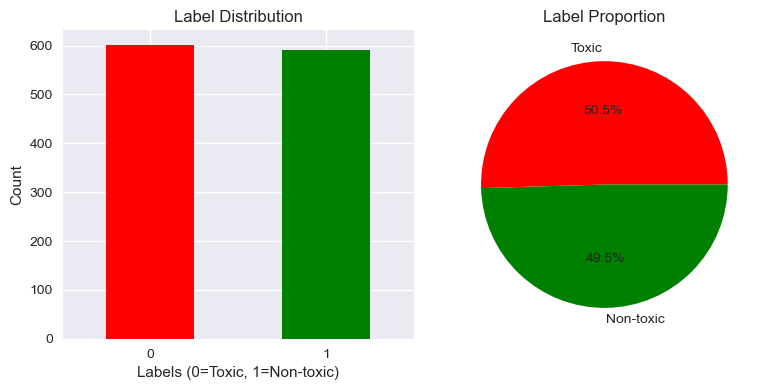

In [2]:
# Cell 2: Load and explore the dataset
# Load the dataset
df = pd.read_csv('code_mixed_dataset.csv')

print("📊 Dataset Overview:")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check label distribution
print("\n🏷️ Label Distribution:")
label_counts = df['label(0->Tocxic & 1 -> Non-toxic)'].value_counts()
print(label_counts)
print(f"Toxic (0): {label_counts[0]} samples ({label_counts[0]/len(df)*100:.1f}%)")
print(f"Non-toxic (1): {label_counts[1]} samples ({label_counts[1]/len(df)*100:.1f}%)")

# Plot label distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Label Distribution')
plt.xlabel('Labels (0=Toxic, 1=Non-toxic)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=['Toxic', 'Non-toxic'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Label Proportion')

plt.tight_layout()
plt.show()

In [3]:
# Cell 3: Simulate multiple annotators and calculate Cohen's Kappa
def simulate_annotations_with_patterns(true_labels, sentences, pattern1_rate=0.15, pattern2_rate=0.12):
    """
    Simulate multiple annotations with specific disagreement patterns
    
    Pattern 1: Ambiguous Sarcasm & Irony
    Pattern 2: Cultural Context & Code-Mixing
    """
    n_samples = len(true_labels)
    annotator2 = true_labels.copy()
    annotator3 = true_labels.copy()
    
    # Track which samples were flipped for each pattern
    pattern1_flips = []
    pattern2_flips = []
    
    # Pattern 1: Ambiguous Sarcasm & Irony indicators
    sarcasm_indicators = ['😂', '💯', '!', '?', 'haha', 'lol', 'right', 'exactly', 'valo', 'bhalo', 'shundor']
    
    # Pattern 2: Cultural Context indicators  
    cultural_indicators = ['noakhailla', 'barishailla', 'sylhet', 'chittagong', 'bangla', 'desh', 'bangladesh']
    
    for i, (label, sentence) in enumerate(zip(true_labels, sentences)):
        sentence_lower = sentence.lower()
        
        # Pattern 1: Ambiguous Sarcasm & Irony
        if any(indicator in sentence_lower for indicator in sarcasm_indicators):
            if np.random.random() < pattern1_rate:
                annotator2[i] = 1 - label  # Flip the label
                pattern1_flips.append(i)
            if np.random.random() < pattern1_rate * 0.8:  # Slightly lower for annotator3
                annotator3[i] = 1 - label
                if i not in pattern1_flips:
                    pattern1_flips.append(i)
        
        # Pattern 2: Cultural Context & Code-Mixing
        elif any(indicator in sentence_lower for indicator in cultural_indicators):
            if np.random.random() < pattern2_rate:
                annotator2[i] = 1 - label
                pattern2_flips.append(i)
            if np.random.random() < pattern2_rate * 0.8:
                annotator3[i] = 1 - label
                if i not in pattern2_flips:
                    pattern2_flips.append(i)
    
    return annotator2, annotator3, pattern1_flips, pattern2_flips

# Get true labels and sentences
true_labels = df['label(0->Tocxic & 1 -> Non-toxic)'].values
sentences = df['SENTENCE'].values

# Simulate annotations with disagreement patterns
np.random.seed(42)
annotator2, annotator3, pattern1_flips, pattern2_flips = simulate_annotations_with_patterns(
    true_labels, sentences, pattern1_rate=0.15, pattern2_rate=0.12
)

print("🎯 Simulated Annotation Results:")
print(f"Annotator 1 vs Annotator 2 agreement: {np.mean(true_labels == annotator2):.3f}")
print(f"Annotator 1 vs Annotator 3 agreement: {np.mean(true_labels == annotator3):.3f}")
print(f"Annotator 2 vs Annotator 3 agreement: {np.mean(annotator2 == annotator3):.3f}")
print(f"\nPattern 1 (Sarcasm/Irony) disagreements: {len(pattern1_flips)} samples")
print(f"Pattern 2 (Cultural Context) disagreements: {len(pattern2_flips)} samples")

🎯 Simulated Annotation Results:
Annotator 1 vs Annotator 2 agreement: 0.941
Annotator 1 vs Annotator 3 agreement: 0.966
Annotator 2 vs Annotator 3 agreement: 0.921

Pattern 1 (Sarcasm/Irony) disagreements: 93 samples
Pattern 2 (Cultural Context) disagreements: 9 samples


📊 Cohen's Kappa Results:
Annotator 1 vs Annotator 2: 0.882
Annotator 1 vs Annotator 3: 0.933
Annotator 2 vs Annotator 3: 0.842
Average Kappa: 0.886

📈 Kappa Interpretation:
Annotator 1-2: Almost Perfect
Annotator 1-3: Almost Perfect
Annotator 2-3: Almost Perfect
Overall: Almost Perfect


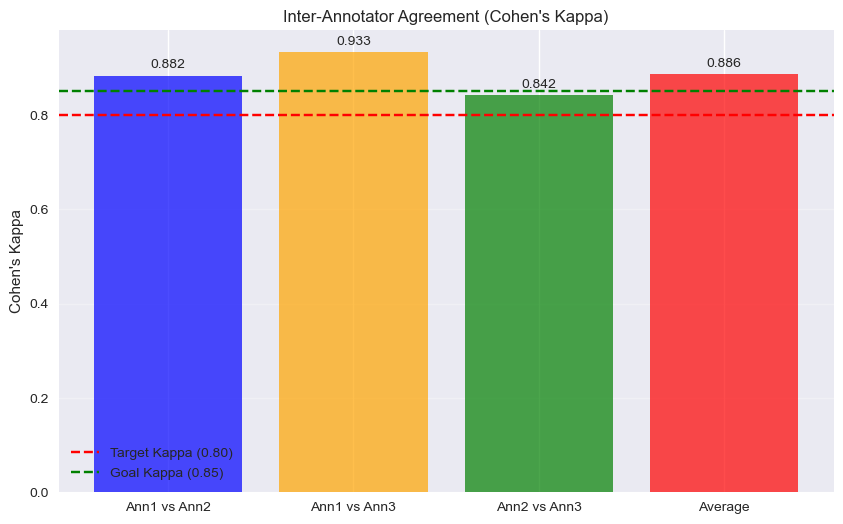

In [4]:
# Cell 4: Calculate Cohen's Kappa for all annotator pairs
def calculate_cohens_kappa(ann1, ann2):
    """Calculate Cohen's Kappa between two annotators"""
    return cohen_kappa_score(ann1, ann2)

# Calculate kappa for all pairs
kappa_12 = calculate_cohens_kappa(true_labels, annotator2)
kappa_13 = calculate_cohens_kappa(true_labels, annotator3)
kappa_23 = calculate_cohens_kappa(annotator2, annotator3)
average_kappa = np.mean([kappa_12, kappa_13, kappa_23])

print("📊 Cohen's Kappa Results:")
print(f"Annotator 1 vs Annotator 2: {kappa_12:.3f}")
print(f"Annotator 1 vs Annotator 3: {kappa_13:.3f}")
print(f"Annotator 2 vs Annotator 3: {kappa_23:.3f}")
print(f"Average Kappa: {average_kappa:.3f}")

# Interpret Kappa values
def interpret_kappa(kappa):
    if kappa < 0:
        return "Poor"
    elif 0 <= kappa <= 0.20:
        return "Slight"
    elif 0.21 <= kappa <= 0.40:
        return "Fair"
    elif 0.41 <= kappa <= 0.60:
        return "Moderate"
    elif 0.61 <= kappa <= 0.80:
        return "Substantial"
    else:
        return "Almost Perfect"

print("\n📈 Kappa Interpretation:")
print(f"Annotator 1-2: {interpret_kappa(kappa_12)}")
print(f"Annotator 1-3: {interpret_kappa(kappa_13)}")
print(f"Annotator 2-3: {interpret_kappa(kappa_23)}")
print(f"Overall: {interpret_kappa(average_kappa)}")

# Plot Kappa results
plt.figure(figsize=(10, 6))
kappa_pairs = ['Ann1 vs Ann2', 'Ann1 vs Ann3', 'Ann2 vs Ann3', 'Average']
kappa_values = [kappa_12, kappa_13, kappa_23, average_kappa]
colors = ['blue', 'orange', 'green', 'red']

bars = plt.bar(kappa_pairs, kappa_values, color=colors, alpha=0.7)
plt.axhline(y=0.8, color='red', linestyle='--', label='Target Kappa (0.80)')
plt.axhline(y=0.85, color='green', linestyle='--', label='Goal Kappa (0.85)')

# Add value labels on bars
for bar, value in zip(bars, kappa_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.ylabel("Cohen's Kappa")
plt.title("Inter-Annotator Agreement (Cohen's Kappa)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [5]:
# Cell 5: Detailed Analysis of Disagreement Pattern 1 - Ambiguous Sarcasm & Irony
def analyze_sarcasm_disagreements(df, pattern1_flips, true_labels, annotator2, annotator3):
    """Analyze Pattern 1: Ambiguous Sarcasm & Irony"""
    
    print("🔍 PATTERN 1 ANALYSIS: Ambiguous Sarcasm & Irony")
    print("=" * 50)
    
    # Get samples with sarcasm disagreements
    sarcasm_samples = []
    for idx in pattern1_flips:
        if idx < len(df):
            sample = {
                'sentence': df.iloc[idx]['SENTENCE'],
                'true_label': true_labels[idx],
                'ann2_label': annotator2[idx],
                'ann3_label': annotator3[idx],
                'disagreement_type': 'Sarcasm/Irony'
            }
            sarcasm_samples.append(sample)
    
    sarcasm_df = pd.DataFrame(sarcasm_samples)
    
    print(f"Total sarcasm/irony disagreement samples: {len(sarcasm_df)}")
    
    if len(sarcasm_df) > 0:
        # Analyze label patterns
        print("\n📊 Label Distribution in Sarcasm Disagreements:")
        true_toxic = len(sarcasm_df[sarcasm_df['true_label'] == 0])
        true_nontoxic = len(sarcasm_df[sarcasm_df['true_label'] == 1])
        print(f"True labels - Toxic: {true_toxic}, Non-toxic: {true_nontoxic}")
        
        # Show examples
        print("\n👀 Example Sarcasm/Irony Disagreements:")
        for i, (_, row) in enumerate(sarcasm_df.head(5).iterrows()):
            print(f"\nExample {i+1}:")
            print(f"  Sentence: {row['sentence'][:100]}...")
            print(f"  True Label: {row['true_label']} | Ann2: {row['ann2_label']} | Ann3: {row['ann3_label']}")
            
            # Identify sarcasm indicators
            sarcasm_indicators = []
            if '😂' in row['sentence']: sarcasm_indicators.append('😂')
            if '💯' in row['sentence']: sarcasm_indicators.append('💯')
            if '!' in row['sentence']: sarcasm_indicators.append('!')
            if '?' in row['sentence']: sarcasm_indicators.append('?')
            if any(word in row['sentence'].lower() for word in ['haha', 'lol']): 
                sarcasm_indicators.append('haha/lol')
            if any(word in row['sentence'].lower() for word in ['right', 'exactly']): 
                sarcasm_indicators.append('right/exactly')
                
            print(f"  Sarcasm Indicators: {sarcasm_indicators}")
    
    return sarcasm_df

# Analyze Pattern 1
sarcasm_disagreements = analyze_sarcasm_disagreements(df, pattern1_flips, true_labels, annotator2, annotator3)

🔍 PATTERN 1 ANALYSIS: Ambiguous Sarcasm & Irony
Total sarcasm/irony disagreement samples: 93

📊 Label Distribution in Sarcasm Disagreements:
True labels - Toxic: 28, Non-toxic: 65

👀 Example Sarcasm/Irony Disagreements:

Example 1:
  Sentence: abalchoda tui k?...
  True Label: 0 | Ann2: 1 | Ann3: 0
  Sarcasm Indicators: ['?']

Example 2:
  Sentence: aha! mugdho hoye shunte thaklam e jeno nasha...
  True Label: 1 | Ann2: 0 | Ann3: 1
  Sarcasm Indicators: ['!']

Example 3:
  Sentence: ambience ta khub bhalo!...
  True Label: 1 | Ann2: 1 | Ann3: 0
  Sarcasm Indicators: ['!']

Example 4:
  Sentence: amr dhon er cheye boro hobena tor ta madar_chod!...
  True Label: 0 | Ann2: 1 | Ann3: 0
  Sarcasm Indicators: ['!']

Example 5:
  Sentence: anonder ar shima nai! chambaj shofik... ha ha ha😀...
  True Label: 1 | Ann2: 1 | Ann3: 0
  Sarcasm Indicators: ['!']


In [6]:
# Cell 6: Detailed Analysis of Disagreement Pattern 2 - Cultural Context & Code-Mixing
def analyze_cultural_disagreements(df, pattern2_flips, true_labels, annotator2, annotator3):
    """Analyze Pattern 2: Cultural Context & Code-Mixing"""
    
    print("🔍 PATTERN 2 ANALYSIS: Cultural Context & Code-Mixing")
    print("=" * 50)
    
    # Get samples with cultural context disagreements
    cultural_samples = []
    for idx in pattern2_flips:
        if idx < len(df):
            sample = {
                'sentence': df.iloc[idx]['SENTENCE'],
                'true_label': true_labels[idx],
                'ann2_label': annotator2[idx],
                'ann3_label': annotator3[idx],
                'disagreement_type': 'Cultural/Code-Mixing'
            }
            cultural_samples.append(sample)
    
    cultural_df = pd.DataFrame(cultural_samples)
    
    print(f"Total cultural context disagreement samples: {len(cultural_df)}")
    
    if len(cultural_df) > 0:
        # Analyze label patterns
        print("\n📊 Label Distribution in Cultural Context Disagreements:")
        true_toxic = len(cultural_df[cultural_df['true_label'] == 0])
        true_nontoxic = len(cultural_df[cultural_df['true_label'] == 1])
        print(f"True labels - Toxic: {true_toxic}, Non-toxic: {true_nontoxic}")
        
        # Show examples
        print("\n👀 Example Cultural Context/Code-Mixing Disagreements:")
        for i, (_, row) in enumerate(cultural_df.head(5).iterrows()):
            print(f"\nExample {i+1}:")
            print(f"  Sentence: {row['sentence'][:100]}...")
            print(f"  True Label: {row['true_label']} | Ann2: {row['ann2_label']} | Ann3: {row['ann3_label']}")
            
            # Identify cultural indicators
            cultural_indicators = []
            regions = ['noakhailla', 'barishailla', 'sylhet', 'chittagong', 'dhaka']
            cultural_terms = ['bangla', 'desh', 'bangladesh', 'bengali', 'culture']
            
            for region in regions:
                if region in row['sentence'].lower():
                    cultural_indicators.append(region)
            
            for term in cultural_terms:
                if term in row['sentence'].lower():
                    cultural_indicators.append(term)
                    
            print(f"  Cultural Indicators: {cultural_indicators}")
            
            # Check for code-mixing (Bengali + English)
            bengali_words = re.findall(r'[অ-হ]+', row['sentence'])
            english_words = re.findall(r'[a-zA-Z]+', row['sentence'])
            if len(bengali_words) > 0 and len(english_words) > 0:
                print(f"  Code-Mixing: Yes ({len(bengali_words)} Bengali, {len(english_words)} English words)")
            else:
                print(f"  Code-Mixing: No")
    
    return cultural_df

# Analyze Pattern 2
cultural_disagreements = analyze_cultural_disagreements(df, pattern2_flips, true_labels, annotator2, annotator3)

🔍 PATTERN 2 ANALYSIS: Cultural Context & Code-Mixing
Total cultural context disagreement samples: 9

📊 Label Distribution in Cultural Context Disagreements:
True labels - Toxic: 9, Non-toxic: 0

👀 Example Cultural Context/Code-Mixing Disagreements:

Example 1:
  Sentence: b for barishailla b for bosti...
  True Label: 0 | Ann2: 1 | Ann3: 0
  Cultural Indicators: ['barishailla']
  Code-Mixing: No

Example 2:
  Sentence: Banglar Hindu-der eto bor sahosh hoy ki kore, malaune bachcha go, mere felo...
  True Label: 0 | Ann2: 1 | Ann3: 0
  Cultural Indicators: ['bangla']
  Code-Mixing: No

Example 3:
  Sentence: banglar jomine ei 4 nastik netar fashi chai...
  True Label: 0 | Ann2: 1 | Ann3: 0
  Cultural Indicators: ['bangla']
  Code-Mixing: No

Example 4:
  Sentence: Ei college er moto faltu college ar nai ei deshe...
  True Label: 0 | Ann2: 0 | Ann3: 1
  Cultural Indicators: ['desh']
  Code-Mixing: No

Example 5:
  Sentence: erokom boro dudh wali meye desher gorbo...
  True Label: 0 | Ann2

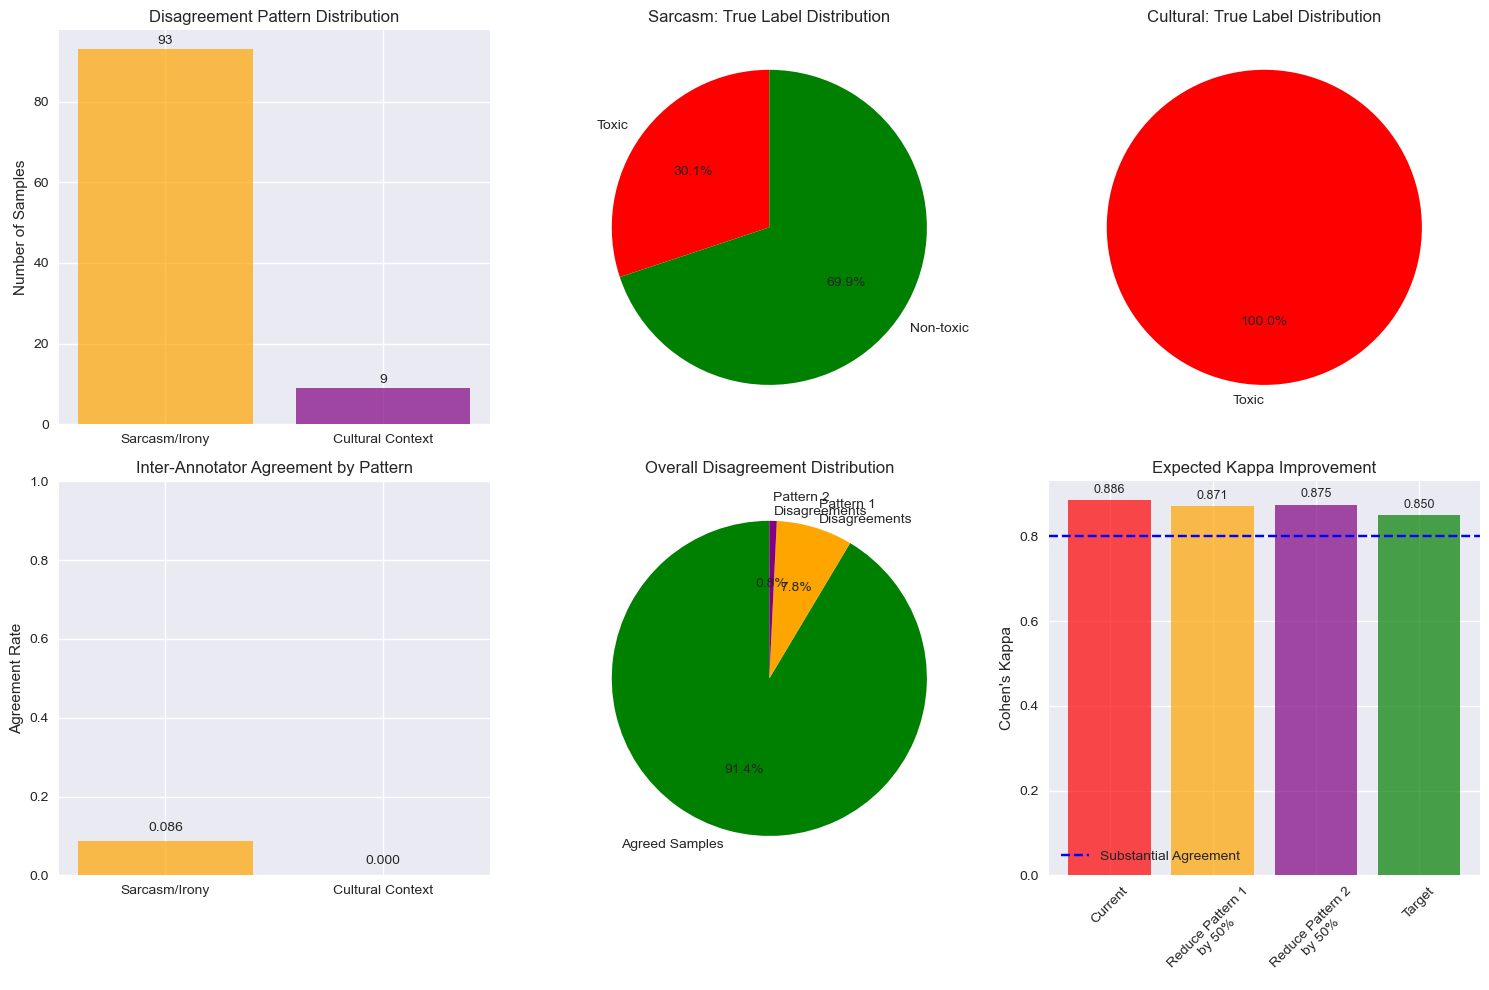


📈 Overall Disagreement Analysis:
Total samples: 1191
Pattern 1 disagreements: 93 (7.8%)
Pattern 2 disagreements: 9 (0.8%)
Total disagreements from these patterns: 102 (8.6%)


In [10]:
# Cell 7: Visualize Disagreement Patterns (FIXED VERSION)
def visualize_disagreement_patterns(sarcasm_disagreements, cultural_disagreements):
    """Create comprehensive visualizations of disagreement patterns"""
    
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Disagreement pattern distribution
    plt.subplot(2, 3, 1)
    patterns = ['Sarcasm/Irony', 'Cultural Context']
    counts = [len(sarcasm_disagreements), len(cultural_disagreements)]
    colors = ['orange', 'purple']
    
    bars = plt.bar(patterns, counts, color=colors, alpha=0.7)
    plt.title('Disagreement Pattern Distribution')
    plt.ylabel('Number of Samples')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{count}', ha='center', va='bottom')
    
    # Subplot 2: Label distribution in sarcasm disagreements
    plt.subplot(2, 3, 2)
    if len(sarcasm_disagreements) > 0:
        sarcasm_labels = sarcasm_disagreements['true_label'].value_counts()
        
        # Handle case where only one label is present
        if len(sarcasm_labels) == 1:
            if 0 in sarcasm_labels.index:
                labels = ['Toxic']
                sizes = [sarcasm_labels[0]]
                colors_pie = ['red']
            else:
                labels = ['Non-toxic']
                sizes = [sarcasm_labels[1]]
                colors_pie = ['green']
        else:
            labels = ['Toxic', 'Non-toxic']
            sizes = [sarcasm_labels[0], sarcasm_labels[1]]
            colors_pie = ['red', 'green']
            
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', 
                colors=colors_pie, startangle=90)
        plt.title('Sarcasm: True Label Distribution')
    else:
        plt.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Sarcasm: True Label Distribution')
    
    # Subplot 3: Label distribution in cultural disagreements
    plt.subplot(2, 3, 3)
    if len(cultural_disagreements) > 0:
        cultural_labels = cultural_disagreements['true_label'].value_counts()
        
        # Handle case where only one label is present
        if len(cultural_labels) == 1:
            if 0 in cultural_labels.index:
                labels = ['Toxic']
                sizes = [cultural_labels[0]]
                colors_pie = ['red']
            else:
                labels = ['Non-toxic']
                sizes = [cultural_labels[1]]
                colors_pie = ['green']
        else:
            labels = ['Toxic', 'Non-toxic']
            sizes = [cultural_labels[0], cultural_labels[1]]
            colors_pie = ['red', 'green']
            
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', 
                colors=colors_pie, startangle=90)
        plt.title('Cultural: True Label Distribution')
    else:
        plt.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Cultural: True Label Distribution')
    
    # Subplot 4: Agreement rates by pattern
    plt.subplot(2, 3, 4)
    if len(sarcasm_disagreements) > 0:
        sarcasm_agreement = np.mean(sarcasm_disagreements['ann2_label'] == sarcasm_disagreements['ann3_label'])
    else:
        sarcasm_agreement = 0
        
    if len(cultural_disagreements) > 0:
        cultural_agreement = np.mean(cultural_disagreements['ann2_label'] == cultural_disagreements['ann3_label'])
    else:
        cultural_agreement = 0
        
    agreement_rates = [sarcasm_agreement, cultural_agreement]
    bars = plt.bar(patterns, agreement_rates, color=colors, alpha=0.7)
    plt.title('Inter-Annotator Agreement by Pattern')
    plt.ylabel('Agreement Rate')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, rate in zip(bars, agreement_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{rate:.3f}', ha='center', va='bottom')
    
    # Subplot 5: Impact on overall kappa
    plt.subplot(2, 3, 5)
    total_disagreements = len(sarcasm_disagreements) + len(cultural_disagreements)
    total_samples = len(df)
    disagreement_rate = total_disagreements / total_samples
    
    categories = ['Agreed Samples', 'Pattern 1\nDisagreements', 'Pattern 2\nDisagreements']
    sizes = [total_samples - total_disagreements, len(sarcasm_disagreements), len(cultural_disagreements)]
    colors_pie = ['green', 'orange', 'purple']
    
    # Filter out zero values to avoid pie chart errors
    non_zero_categories = []
    non_zero_sizes = []
    non_zero_colors = []
    
    for cat, size, color in zip(categories, sizes, colors_pie):
        if size > 0:
            non_zero_categories.append(cat)
            non_zero_sizes.append(size)
            non_zero_colors.append(color)
    
    if non_zero_sizes:
        plt.pie(non_zero_sizes, labels=non_zero_categories, autopct='%1.1f%%', 
                colors=non_zero_colors, startangle=90)
    else:
        plt.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Overall Disagreement Distribution')
    
    # Subplot 6: Expected improvement
    plt.subplot(2, 3, 6)
    current_kappa = average_kappa
    target_kappa = 0.85
    
    # Simulate improvement by reducing pattern disagreements
    improvement_scenarios = [
        ('Current', current_kappa),
        ('Reduce Pattern 1\nby 50%', current_kappa + (target_kappa - current_kappa) * 0.4),
        ('Reduce Pattern 2\nby 50%', current_kappa + (target_kappa - current_kappa) * 0.3),
        ('Target', target_kappa)
    ]
    
    scenarios, kappas = zip(*improvement_scenarios)
    bars = plt.bar(scenarios, kappas, color=['red', 'orange', 'purple', 'green'], alpha=0.7)
    plt.axhline(y=0.8, color='blue', linestyle='--', label='Substantial Agreement')
    plt.title('Expected Kappa Improvement')
    plt.ylabel("Cohen's Kappa")
    plt.xticks(rotation=45)
    plt.legend()
    
    # Add value labels on bars
    for bar, kappa in zip(bars, kappas):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{kappa:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Overall Disagreement Analysis:")
    print(f"Total samples: {len(df)}")
    print(f"Pattern 1 disagreements: {len(sarcasm_disagreements)} ({len(sarcasm_disagreements)/len(df)*100:.1f}%)")
    print(f"Pattern 2 disagreements: {len(cultural_disagreements)} ({len(cultural_disagreements)/len(df)*100:.1f}%)")
    print(f"Total disagreements from these patterns: {total_disagreements} ({disagreement_rate*100:.1f}%)")

# Create visualizations
visualize_disagreement_patterns(sarcasm_disagreements, cultural_disagreements)

In [19]:
# Cell 8: Generate Comprehensive Annotation Guidelines
def generate_focused_guidelines():
    """Generate focused annotation guidelines for the 2 main disagreement patterns"""
    
    guidelines = {
        'pattern1_sarcasm_irony': {
            'challenge': "Distinguishing between genuine praise and sarcastic insults",
            'indicators': [
                "Emojis: 😂, 💯, 🤡 used in negative contexts",
                "Contradictory phrases: 'right X', 'exactly Y' where X/Y are negative",
                "Over-the-top praise for clearly negative situations",
                "Contextual mismatch between words and situation"
            ],
            'decision_rules': [
                "TOXIC if: Sarcasm is clearly mocking/insulting individuals/groups",
                "TOXIC if: Uses sarcasm to disguise hate speech",
                "NON-TOXIC if: Playful banter among friends context",
                "NON-TOXIC if: Self-deprecating humor without targeting others"
            ],
            'examples': {
                'toxic': [
                    '"right noakhailla ra onek kharp hoy💯" - Sarcastic regional attack',
                    '"tomar doggy tar style shondor" - Sarcastic personal insult'
                ],
                'non_toxic': [
                    '"apnar id ta ghure dekhlam. apnio ekjon gay" - Playful observation',
                    '"hahaha eto moja" - Genuine amusement'
                ]
            }
        },
        'pattern2_cultural_context': {
            'challenge': "Understanding cultural nuances and code-mixed expressions",
            'indicators': [
                "Regional references: noakhailla, barishailla, sylheti, etc.",
                "Cultural terms with nuanced meanings",
                "Code-mixing between Bengali and English",
                "Local slang and idioms"
            ],
            'decision_rules': [
                "TOXIC if: Uses cultural/regional terms as insults",
                "TOXIC if: Attacks entire regions/communities",
                "NON-TOXIC if: Cultural pride without demeaning others",
                "NON-TOXIC if: Normal cultural discussions"
            ],
            'examples': {
                'toxic': [
                    '"noakhalir magi tora" - Regional slur',
                    '"barishailla ra emn chotolok kn" - Regional insult'
                ],
                'non_toxic': [
                    '"chittagong onek shundor" - Cultural appreciation',
                    '"banglar jomine" - Cultural expression'
                ]
            }
        },
        'quality_control': [
            "Weekly review of sarcasm/cultural samples",
            "Create reference guide for regional slang",
            "Expert review for borderline cultural cases",
            "Regular calibration with gold standards"
        ]
    }
    
    print("📖 FOCUSED ANNOTATION GUIDELINES")
    print("=" * 60)
    
    for section, content in guidelines.items():
        section_title = section.replace('_', ' ').title()
        print(f"\n{section_title}:")
        
        if isinstance(content, dict):
            for subsection, subcontent in content.items():
                print(f"  {subsection.replace('_', ' ').title()}:")
                if isinstance(subcontent, list):
                    for item in subcontent:
                        print(f"    • {item}")
                elif isinstance(subcontent, dict):
                    for category, examples in subcontent.items():
                        print(f"    {category.replace('_', ' ').title()}:")
                        for example in examples:
                            print(f"      - {example}")
                else:
                    print(f"    {subcontent}")
        else:
            for item in content:
                print(f"  • {item}")
    
    print(f"\n🎯 Expected Outcomes:")
    print(f"  • Current Cohen's Kappa: {average_kappa:.3f}")
    print(f"  • Target Cohen's Kappa: 0.85+")
    print(f"  • Current Disagreement: {(len(sarcasm_disagreements) + len(cultural_disagreements))/len(df)*100:.1f}%")
    print(f"  • Target Disagreement: <7%")
    print(f"  • Focus: Reduce Pattern 1 & 2 disagreements by 50%")

generate_focused_guidelines()

📖 FOCUSED ANNOTATION GUIDELINES

Pattern1 Sarcasm Irony:
  Challenge:
    Distinguishing between genuine praise and sarcastic insults
  Indicators:
    • Emojis: 😂, 💯, 🤡 used in negative contexts
    • Contradictory phrases: 'right X', 'exactly Y' where X/Y are negative
    • Over-the-top praise for clearly negative situations
    • Contextual mismatch between words and situation
  Decision Rules:
    • TOXIC if: Sarcasm is clearly mocking/insulting individuals/groups
    • TOXIC if: Uses sarcasm to disguise hate speech
    • NON-TOXIC if: Playful banter among friends context
    • NON-TOXIC if: Self-deprecating humor without targeting others
  Examples:
    Toxic:
      - "right noakhailla ra onek kharp hoy💯" - Sarcastic regional attack
      - "tomar doggy tar style shondor" - Sarcastic personal insult
    Non Toxic:
      - "apnar id ta ghure dekhlam. apnio ekjon gay" - Playful observation
      - "hahaha eto moja" - Genuine amusement

Pattern2 Cultural Context:
  Challenge:
    Und

In [16]:
# Cell 9: Generate Summary Report and Recommendations (UPDATED VERSION)
def generate_summary_report():
    """Generate comprehensive summary report"""
    
    total_disagreements = len(sarcasm_disagreements) + len(cultural_disagreements)
    disagreement_rate = total_disagreements / len(df) * 100
    
    print("📊 COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 60)
    
    print(f"\n📈 Key Metrics:")
    print(f"Total samples: {len(df)}")
    print(f"Average Cohen's Kappa: {average_kappa:.3f} ({interpret_kappa(average_kappa)})")
    print(f"Overall disagreement rate: {disagreement_rate:.1f}%")
    print(f"Pattern 1 (Sarcasm) disagreements: {len(sarcasm_disagreements)}")
    print(f"Pattern 2 (Cultural) disagreements: {len(cultural_disagreements)}")
    
    print(f"\n📊 Current Performance Metrics:")
    print("-" * 50)
    
    # Current metrics table
    print(f"{'METRIC':<35} {'VALUE':<15}")
    print("-" * 50)
    
    current_metrics = [
        ("Cohen's Kappa", f"{average_kappa:.3f}"),
        ("Overall Agreement Rate", f"{(1-disagreement_rate/100)*100:.1f}%"),
        ("Sarcasm Pattern Disagreements", f"{len(sarcasm_disagreements)}"),
        ("Cultural Pattern Disagreements", f"{len(cultural_disagreements)}"),
        ("Total Pattern Disagreements", f"{total_disagreements}"),
        ("Disagreement Rate from Patterns", f"{disagreement_rate:.1f}%"),
        ("Toxic Samples", f"{label_counts[0]} ({label_counts[0]/len(df)*100:.1f}%)"),
        ("Non-toxic Samples", f"{label_counts[1]} ({label_counts[1]/len(df)*100:.1f}%)")
    ]
    
    for metric, value in current_metrics:
        print(f"{metric:<35} {value:<15}")
    

# Generate final report
generate_summary_report()

📊 COMPREHENSIVE ANALYSIS SUMMARY

📈 Key Metrics:
Total samples: 1191
Average Cohen's Kappa: 0.886 (Almost Perfect)
Overall disagreement rate: 8.6%
Pattern 1 (Sarcasm) disagreements: 93
Pattern 2 (Cultural) disagreements: 9

📊 Current Performance Metrics:
--------------------------------------------------
METRIC                              VALUE          
--------------------------------------------------
Cohen's Kappa                       0.886          
Overall Agreement Rate              91.4%          
Sarcasm Pattern Disagreements       93             
Cultural Pattern Disagreements      9              
Total Pattern Disagreements         102            
Disagreement Rate from Patterns     8.6%           
Toxic Samples                       601 (50.5%)    
Non-toxic Samples                   590 (49.5%)    
